# Imports

In [13]:
import os

assert os.getcwd().split('/')[-1] == 'ot_hallucination', 'Please make sure you are situated in the right place'
!python dl_weights.py
import fairseq
from tokenizer import Tokenizer
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set_style('white')



Download script for OT for Hallucination detection

 Everything is present


## Loading tokenizer and model 

In [10]:
tokenizer = Tokenizer()
model = fairseq.models.transformer.TransformerModel.from_pretrained('checkpoint',
    checkpoint_file='checkpoint_best.pt',
    data_name_or_path = 'data/wmt18_de-en',
)
model.eval()

2023-02-21 08:57:59 | INFO | fairseq.file_utils | loading archive file checkpoint
2023-02-21 08:57:59 | INFO | fairseq.file_utils | loading archive file data/wmt18_de-en
2023-02-21 08:58:00 | INFO | fairseq.tasks.translation | [de] dictionary: 32032 types
2023-02-21 08:58:00 | INFO | fairseq.tasks.translation | [en] dictionary: 32032 types
2023-02-21 08:58:01 | INFO | fairseq.models.fairseq_model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 10, 'log_format': None, 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': 'mt-hallucinations', 'azureml_logging': False, 'seed': 42, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_

GeneratorHubInterface(
  (models): ModuleList(
    (0): TransformerModel(
      (encoder): TransformerEncoderBase(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(32032, 512, padding_idx=1)
        (embed_positions): SinusoidalPositionalEmbedding()
        (layers): ModuleList(
          (0): TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (dropout_module): FairseqDropout()
            (activation_dropout_module): FairseqDropout()
            (fc1): Linear(in_featur

In [12]:
def labelize(line):
    if line['repetitions']==1:
        return 'oscillatory-hall'
    elif line['strong-unsupport']==1 and line['omission']==0 and line['repetitions']==0 :
        if line['full-unsupport']==1:
            print('oy')
        return 'strongly-detached-hall'
    elif line['full-unsupport']==1:
        return 'fully_detached'
    elif line['named-entities']==1 or line['omission']==1 or line['mt'].lower()!=line['ref'].lower():
        return 'incorrect'
    else : return 'correct'

## Computing distributions

In [15]:

if not os.path.isfile('scores.pkl') : 

    df = pd.read_csv('data/annotated_corpus.csv', index_col=0)
    df['label'] = df.apply(labelize, axis=1)


    scores = {"oscillatory-hall":[],"strongly-detached-hall":[], "fully_detached":[], "correct":[],'incorrect':[]   }
    progress = tqdm(total=len(df))
    for cat in scores.keys():
        for _, line in df[df.label == cat].iterrows():
            tokenized_input = tokenizer.encode(line['src'])
            output = model.generate(model.encode(tokenized_input), beam=5)
            attn = output[0]['attention'].mean(axis=1).numpy()
            u = ot.unif(len(attn))
            score = np.sum(np.abs(attn - u))*.5
            scores[cat].append(score)
            progress.update()

    with open("scores.pkl", 'wb') as f :
        pickle.dump(scores,f)

else :
    with open("scores.pkl", 'rb') as f :
        scores=pickle.load(f)

In [16]:
hallucination = scores['oscillatory-hall']+scores["strongly-detached-hall"]+scores["fully_detached"]
r_held = scores['correct']+scores['incorrect']

## Plotting

[]

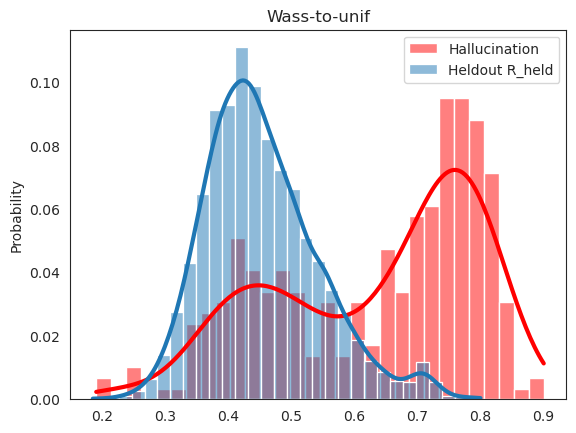

In [18]:
sns.histplot(hallucination, label='Hallucination', kde=True, stat='probability', color='red', bins=30, line_kws={"lw":3})
sns.histplot(r_held, label="Heldout R_held", kde=True, stat='probability', bins=30, line_kws={"lw":3})
plt.legend()
plt.title("Wass-to-unif")
plt.savefig('wass2unif.png')
plt.plot()